# 差分近似

まずはグラフ作成に用いるライブラリの読み込みを行います．

In [2]:
import numpy as np
import sys
if 'google.colab' in sys.modules:
    print("Installing pygmt on Google Colab. It may take a few minutes.")
    ! pip install -q condacolab &> /dev/null
    import condacolab
    condacolab.install()
    ! mamba install pygmt &> /dev/null
import pygmt

## 差分近似

### 前進・後退・中心差分とスタガードグリッド差分

地震波数値シミュレーションで解こうとする運動方程式や構成関係式は微分方程式ですので，このまま簡単に解くことはできません．そこで，微分演算に対してある **近似** を行うことで，この運動方程式を単純な代数方程式に置き換えることを目指します．

微分とは，もともと無限に小さな2点間の関数の値の差として，

$$
f'(x) = \lim_{\Delta x\rightarrow 0} \frac{f(x+\Delta x) - f(x)}{\Delta x}
$$

で定義されるものです．この極限を取らずに，十分に小さい$\Delta x$を使って，微分を

$$
f'(x) \simeq \frac{f(x+\Delta x) - f(x)}{\Delta x}
$$

で評価することにしましょう．これを**差分近似**といいます．

偏微分方程式に現れる空間微分や時間微分をすべて差分近似してしまうと，それはもはやただの連立方程式で，多くの場合コンピュータで代数的に解くことができます．こうして，微分方程式の微分を差分に置き換えてを数値的に解く方法を，一般に **差分法** といいます．

ただし，あくまでもこれは近似解法ですから，この近似を用いた解（数値シミュレーションの結果）が正当なものかは丁寧な検討が必要となります．
そこで，実際に地震波の計算に入る前に，まずは，その「差分」がどの程度正しいのか，調べてみましょう．
関数$f$が**連続**であれば，以下の3つの極限（微分）はみな等しいはずです．

$$
\begin{align*}
&f'(x) = \lim_{\Delta x\rightarrow 0} \frac{f(x+\Delta x) - f(x)}{\Delta x}\\
&f'(x) = \lim_{\Delta x\rightarrow 0} \frac{f(x) - f(x-\Delta x)}{\Delta x}\\
&f'(x) = \lim_{\Delta x\rightarrow 0} \frac{f(x+\Delta x) - f(x-\Delta x)}{2\Delta x}
\end{align*}
$$

ところが，差分法では，極限をとらないがために，この3つの結果が微妙に異なります．
それぞれを **前進差分**・**後退差分**・**中心差分**と呼びます．

ためしに，適当な関数

$$
f(x) = e^x \sin x
$$

を $x=0$ の周りで微分してみましょう．この関数は簡単に微分できて，

$$
f'(x) = e^x(\sin x+\cos x)
$$

ですから，$f'(0)=1$になるはずです．以下の図に関数形状を示します．

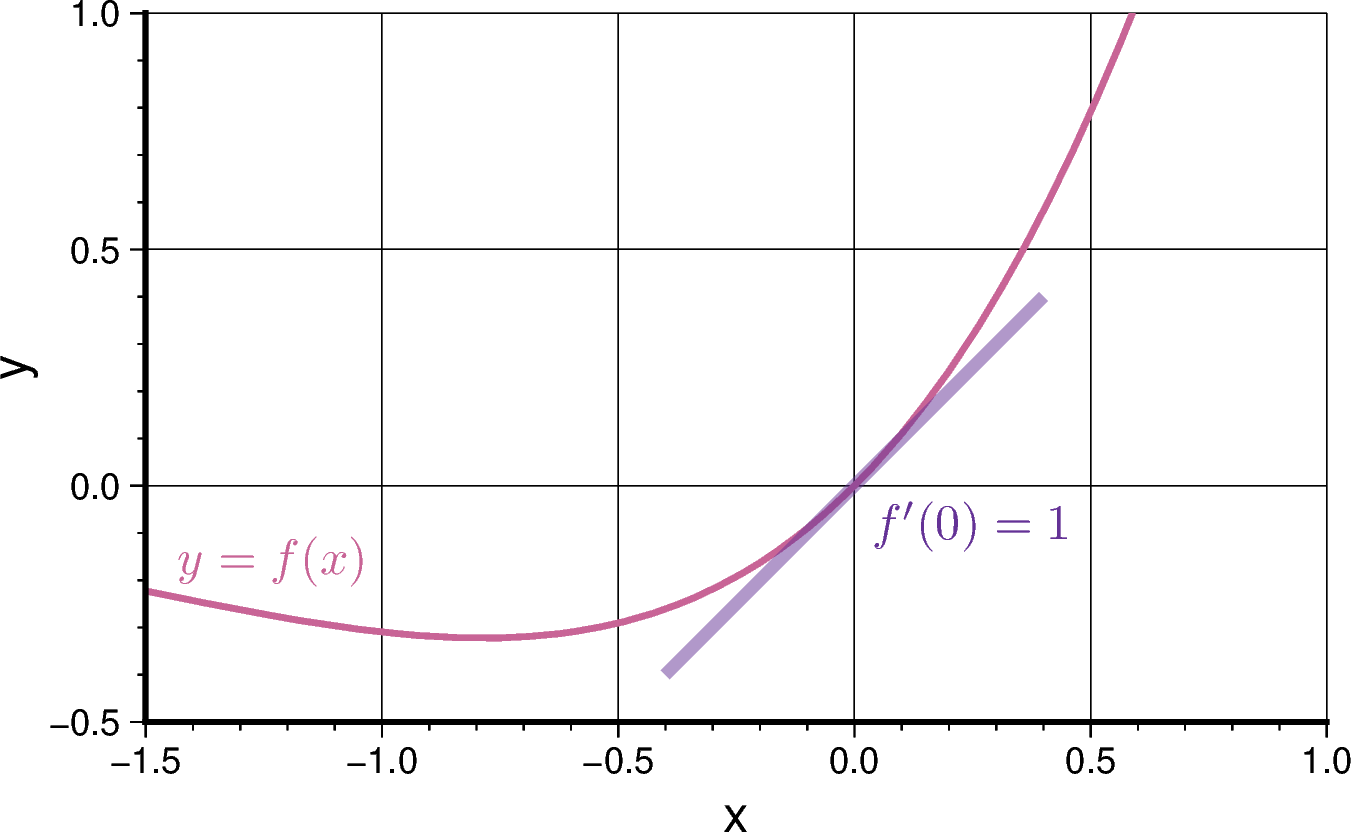

In [3]:
x = np.linspace(-1.5, 1, 201)
y = np.exp(x) * np.sin(x)

fig = pygmt.Figure()
fig.plot(x=x, y=y, frame=['WS', 'xafg+lx', 'yafg+ly'], 
         projection = 'X10c/6c', region = [-1.5, 1, -0.5, 1], 
         pen = 'thicker,200/100/150')
fig.plot(data = [[-0.4,-0.4], [0.4,0.4]], pen='fat,100/50/150@50')
fig.text(x=-1.45,y=-0.22,justify='LB', text="<math>y=f(x)</math>", font='12p,200/100/150')
fig.text(x=0.02,y=-0.02,justify='LT',text="<math>f'(0)=1</math>", font='12p,100/50/150')
fig.show()  

では，先の3種類の近似による微分の評価どうなるでしょうか？関数形状からすると，$x=0$の前後でグラフの傾きが大きく変わるため，前進差分と後退差分とでは値が異なることが予想されます．

実際に $\Delta x$ の値を変数 `dx` として適当に与え，定義通りにこの関数の3通りの差分を計算してみましょう．

In [15]:
dx = 0.5

# 前進差分
df1 = (np.exp(0+dx) * np.sin(0+dx) - np.exp(0   ) * np.sin(0   )) / dx
# 後退差分
df2 = (np.exp(0)    * np.sin(0   ) - np.exp(0-dx) * np.sin(0-dx)) / dx
# 中心差分
df3 = (np.exp(0+dx) * np.sin(0+dx) - np.exp(0-dx) * np.sin(0-dx))/ (2*dx)

## 理論値 f'(0) = 1 との差を表示
print(f"前進差分 {df1:6.3f}, error = {(df1-1):10.3e}")
print(f"後退差分 {df2:6.3f}, error = {(df2-1):10.3e}")
print(f"中央差分 {df3:6.3f}, error = {(df3-1):10.3e}")

前進差分  1.581, error =  5.809e-01
後退差分  0.582, error = -4.184e-01
中央差分  1.081, error =  8.123e-02


> Pythonの文法では，**f-string** といって，クオーテーション記号の前に `f` をつけ，`{変数名:書式}` のように指定することで表示書式を制御できます．

予想通り，前進差分では傾きが大きく，後退差分では小さくなってしまいました．とはいえ，`dx` の幅を小さくしていけば，この差は小さくなる，と直感的には期待できます．

そこで，上記のコードを拡張して，変数 `dx` の値を色々変えて試してみましょう．ドラスティックに値を変えたいので，`np.logspace` という関数で `dx` を用意します． `np.logspace(a, b, n)` は $10^a$から$10^b$までを，対数軸で等間隔になるように$n$分割したリストを作成してくれます．

In [23]:
 dx = np.logspace(-4, 0, 201)

## 3種類の差分で微分係数を近似計算 (dxのすべての値についてまとめて計算）
# 前進差分
df1 = (np.exp(0+dx) * np.sin(0+dx) - np.exp(0   ) * np.sin(0   )) / dx
# 後退差分
df2 = (np.exp(0)    * np.sin(0   ) - np.exp(0-dx) * np.sin(0-dx)) / dx
# 中心差分
df3 = (np.exp(0+dx) * np.sin(0+dx) - np.exp(0-dx) * np.sin(0-dx))/ (2*dx)

# 理論値 f'(0) = 1 との差を計算
err_df1 = np.abs(df1-1.0)
err_df2 = np.abs(df2-1.0)
err_df3 = np.abs(df3-1.0)

結果を可視化してみます．

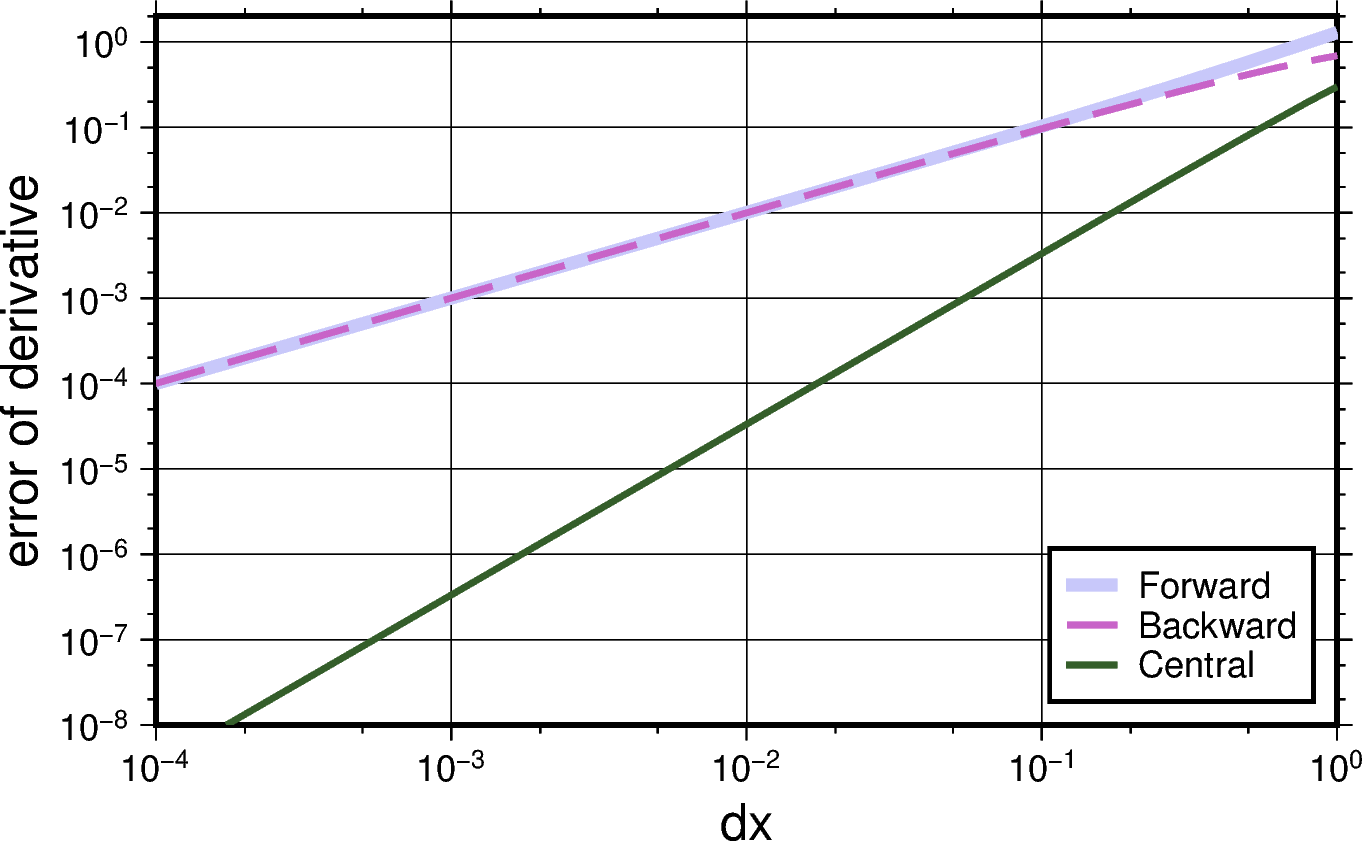

In [24]:
fig = pygmt.Figure()
fig.basemap(projection='X10cl/6cl', 
            region=[1e-4, 1., 1e-08, 2], 
            frame=['WSen', 'xa1f2g1p+ldx', 'ya1f2g1p+lerror of derivative'])
fig.plot(x=dx, y=err_df1, pen = 'fat,200/200/250', label='Forward')
fig.plot(x=dx, y=err_df2, pen = 'thicker,200/100/200,-', label='Backward')
fig.plot(x=dx, y=err_df3, pen = 'thicker,052/094/042', label='Central')
fig.legend(position='JBR+jBR+o0.2c', box='+gwhite+p1p')
fig.show()

結果は興味深いもので，すべての結果が `dx` を小さくすることで誤差が小さくなる（本当の微分値に近づいていく）のですが，前進差分（`Forward`）と後退差分（`Backward`）に比べて，より `dx` に対してより早く誤差が小さくなっています．実は，前進と後退差分はほぼ `dx` に比例して誤差が小さくなる（`dx`が1/10になると誤差が1/10になる）のに対し，中央差分では `dx`の2乗に比例して誤差が小さくなっている（`dx`が1/10になると誤差が1/100になる）ようです．つまり，中央差分のほうが系統的に精度が良い，と言って良さそうです．

このことは数学的にはTaylor展開を通じて次のように理解できます．

$$
  f(x+\Delta x) = f(x) + \frac{df}{dx} \Delta x + \frac{1}{2}\frac{d^2f}{dx^2} \Delta x^2 + \frac{1}{6}\frac{d^3f}{dx^3} \Delta x^3 + \cdots
$$

ですから，前進差分公式に代入すると，

$$
\begin{align}
  \frac{f(x+\Delta x) - f(x)}{\Delta x} =
  \frac{df}{dx} + \frac{1}{2}\frac{d^2f}{dx^2} \Delta x + \cdots
  = \frac{df}{dx} +  \mathcal{O}\left(\Delta x\right)
\end{align}
$$

であることがわかります．ただしここで$\mathcal{O}\left(\Delta x\right)$は$\Delta x$に比例するオーダーのTaylor展開の剰余項です．この表現から，上記の差分式による微分の近似計算は，グリッド間隔$\Delta x$に比例するような誤差を持つことがわかります．誤差が$\Delta x$の一次関数に比例するように小さくなっていくことから，これを **空間1次精度の差分** と呼ぶことがあります．後退差分も全く同じように$\mathcal{O}\left(\Delta x\right)$の誤差を持ちます．

一方，中心差分公式ではどうでしょうか．展開してみると，

$$
\begin{align}
  \frac{ f(x+\Delta x) - f(x-\Delta x)}{ 2 \Delta x } = \frac{df}{dx} + \frac{1}{6}\frac{d^3 f}{d x^3} \Delta x^2 \cdots
  = \frac{df}{dx} + \mathcal{O}\left(\Delta x^2\right)
\end{align}
$$

と，$\Delta x^2$に比例する誤差だけが残りました．したがって中心差分は **2次精度の差分** であり，$\Delta x$を小さくしていくとその2次関数に比例して剰余項が小さくなっていきます．
つまり，前進差分や後退差分よりも，中心差分のほうが，$\Delta x$を小さくしていくにつれて，より誤差が小さくなっていくという意味で，精度が良いのです．

しかし，中心差分は，関数の評価をする地点が$x\pm \Delta x$で，距離が$2\Delta x$離れてしまっています．もしもし関数の値とその微分係数の値の評価点が互いにグリッド間隔の半分（半グリッド）だけずれていてよい，ということを許容できるのならば，$x$における差分を

$$
\begin{align}
  \frac{ f(x+\Delta x/2) - f(x-\Delta x/2)}{ \Delta x } = \frac{df}{dx} + \frac{1}{24}\frac{d^3 f}{d x^3} \Delta x^2 \cdots
  = \frac{df}{dx} + \mathcal{O}\left(\Delta x^2\right)
\end{align}
$$

とすることができます．この新しい方法で得られる微分の精度は，オーダーとしてはもとの中心差分と同じ2次精度ですが，剰余項同士を比較すると，差分を計算する関数評価点の間隔が$2 \Delta x$から$\Delta x$に半減したぶん，その誤差が1/4の大きさになっていることがわかります．

この差分法は関数値と微分の評価位置が互いに食い違っていることから，**スタガードグリッド（staggered grid）差分法**（食い違い格子差分法）と呼ばれています．先程の図に計算精度を追記してみます．

In [25]:
# 中心差分（スタガードグリッド）
df4 = (np.exp(0+dx/2) * np.sin(0+dx/2) - np.exp(0-dx/2) * np.sin(0-dx/2))/ (dx)
err_df4 = np.abs(df4 - 1.0)

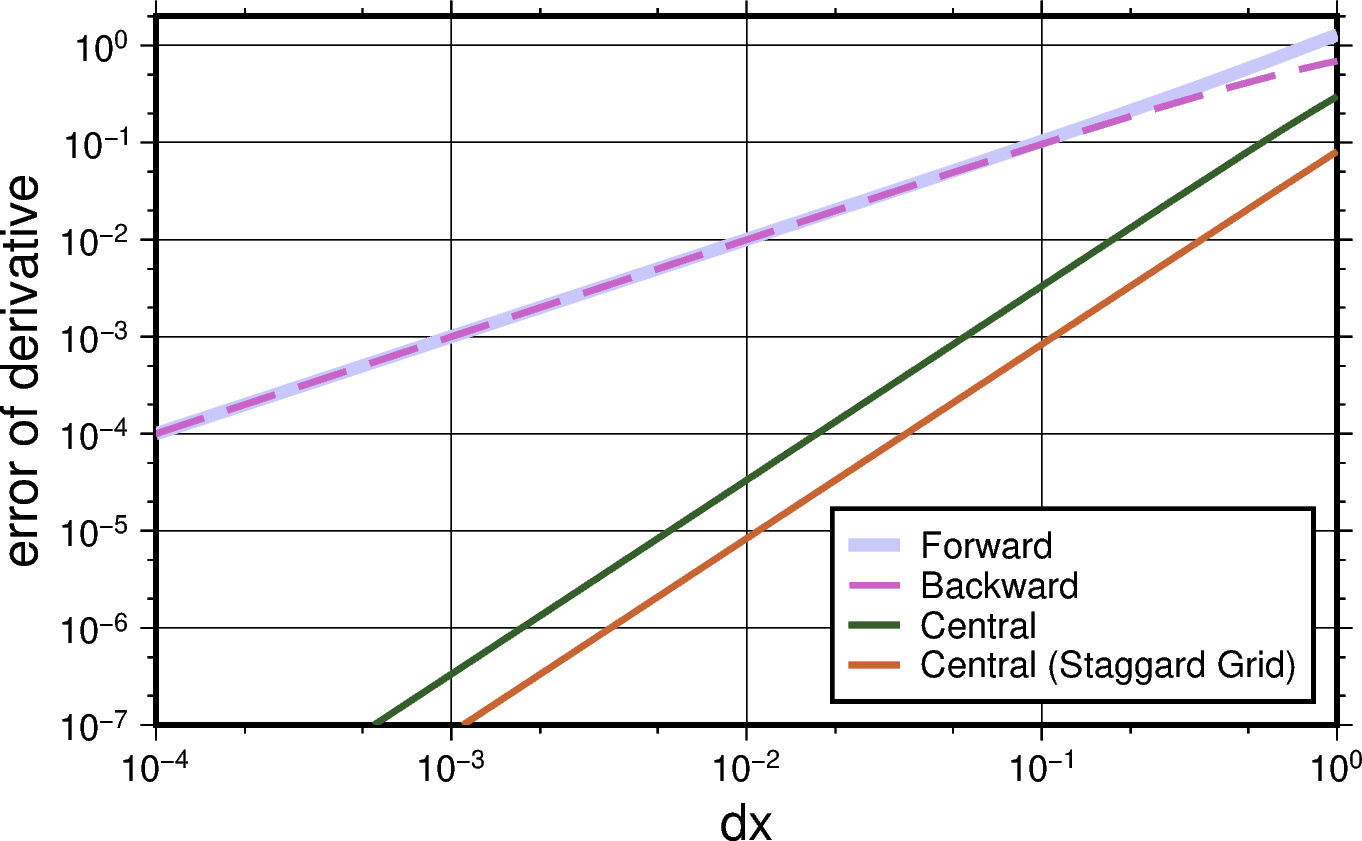

In [26]:
fig = pygmt.Figure()
fig.basemap(projection='X10cl/6cl', 
            region=[1e-4, 1., 1e-07, 2], 
            frame=['WSen', 'xa1f2g1p+ldx', 'ya1f2g1p+lerror of derivative'])
fig.plot(x=dx, y=err_df1, pen = 'fat,200/200/250', label='Forward')
fig.plot(x=dx, y=err_df2, pen = 'thicker,200/100/200,-', label='Backward')
fig.plot(x=dx, y=err_df3, pen = 'thicker,052/094/042', label='Central')
fig.plot(x=dx, y=err_df4, pen = 'thicker,200/100/50',  label='Central (Staggard Grid)')
fig.legend(position='JBR+jBR+o0.2c', box='+gwhite+p1p')
fig.show()

`dx`の2乗に比例するという特徴は変わらないまま，それでもさらに数倍の精度が達成できました．

## 高次差分公式

ここまで紹介した差分法は，ある**2点**における関数値の差を使って微分を近似していました．その差の取り方によって精度が異なることは，Taylor展開をつかって確かめられたのでした．

もっと多くの点の情報を使うことによって，より精度の高い差分法を考えることもできます．たとえば，$x \pm \Delta x$および $x \pm 3 \Delta x / 2 $ の4点を使って微分を近似することを考えます．Taylor展開によると

$$
\begin{align}
		 & f\left(x\pm \frac{\Delta x}{2} \right) =
		f(x) \pm
		\frac{1}{2} \frac{d f}{d x} \Delta x +
		\frac{1}{8} \frac{d^2 f}{d x^2} \Delta x^2 
    \notag \\
    & \qquad \qquad \qquad
    \pm
		\frac{1}{48} \frac{d^3 f}{d x^3} \Delta x^3 +
		\frac{1}{384} \frac{d^4 f}{d x^4} \Delta x^4 + \mathcal{O}(\Delta x^5)
		\\
		 & f\left(x\pm \frac{3 \Delta x}{2} \right) =
		f(x) \pm
		\frac{3}{2} \frac{d f}{d x} \Delta x +
		\frac{9}{8} \frac{d^2 f}{d x^2} \Delta x^2 
    \notag \\
    & \qquad \qquad \qquad    
    \pm
		\frac{9}{16} \frac{d^3 f}{d x^3} \Delta x^3 +
		\frac{27}{128} \frac{d^4 f}{d x^4} \Delta x^4 + \mathcal{O}(\Delta x^5)
\end{align}
$$

ですから，基準点$x$を中心として等距離離れた点同士の差を取ると，

$$
\begin{align}
		 & f\left(x + \frac{\Delta x}{2} \right) - f\left(x -\frac{\Delta x}{2} \right)
		=
		\frac{d f}{d x} \Delta x +
		\frac{1}{24} \frac{d^3 f}{d x^3} \Delta x^3 +  \mathcal{O}(\Delta x^5)
		\\
		 & f\left(x + \frac{3\Delta x}{2} \right) - f\left(x -\frac{3\Delta x}{2} \right)
		=
		3 \frac{d f}{d x} \Delta x +
		\frac{9}{8} \frac{d^3 f}{d x^3} \Delta x^3 + \mathcal{O}(\Delta x^5)
\end{align}
$$

となり，Taylor展開の一部の項がキャンセルされました．さらに$\Delta x^3 $の項をキャンセルするように組み合わせると，最終的に

$$
\begin{align}
	\frac{d f}{d x} &=
	\frac{9}{8\Delta x} \left[ f\left(x + \frac{\Delta x}{2} \right) - f\left(x -\frac{\Delta x}{2} \right) \right]
	\notag \\
	&- \frac{1}{24\Delta x} \left[ f\left(x + \frac{3\Delta x}{2} \right) - f\left(x -\frac{3\Delta x}{2} \right) \right]
	+ \mathcal{O}(\Delta x^4)
\end{align}
$$

が得られます．これは4次精度のスタガードグリッド差分公式です．

より高次の公式も同様の手続きで導出できます．地震波の数値シミュレーションでは，空間16次精度公式くらいまで実用に供された例があるようです．ただし，高次公式になればなるほど，ひとつの場所における微分を計算するためにより多くの周辺の点の情報が必要となるため，計算コストが高くなるとともに，地表や周辺境界における境界条件の扱いが難しくなるという難点もあり，良いことばかりではありません．